# Code
***

# 1pm 07/05 - Different attempt

# Load

In [2]:
# Imports
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.applications import VGG16
import matplotlib.pyplot as plt
import numpy as np
import time
from tensorflow.keras import mixed_precision

# Enable Mixed Precision
policy = mixed_precision.Policy('mixed_float16')
mixed_precision.set_global_policy(policy)

# Load Dataset
student_id_seed = 432121 # Seed for reproducibility

dataset_dir = 'E:\\GUI\\hagridset'  # Path to your dataset directory
image_size = (64, 64)
batch_size = 16
validation_split = 0.2

train_ds = tf.keras.utils.image_dataset_from_directory(
    dataset_dir,
    validation_split=validation_split,
    subset="training",
    seed=student_id_seed,
    image_size=image_size,
    batch_size=batch_size
)
val_ds = tf.keras.utils.image_dataset_from_directory(
    dataset_dir,
    validation_split=validation_split,
    subset="validation",
    seed=student_id_seed,
    image_size=image_size,
    batch_size=batch_size
)

# Save the class names
class_names = train_ds.class_names
num_classes = len(class_names)

# Further split validation set into val and test
val_batches = tf.data.experimental.cardinality(val_ds)
test_ds = val_ds.take((2 * val_batches) // 3)
val_ds = val_ds.skip((2 * val_batches) // 3)

# Cache and prefetch data for performance improvement
AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds.cache().prefetch(buffer_size=AUTOTUNE)


INFO:tensorflow:Mixed precision compatibility check (mixed_float16): OK
Your GPU will likely run quickly with dtype policy mixed_float16 as it has compute capability of at least 7.0. Your GPU: NVIDIA GeForce RTX 4060, compute capability 8.9
Found 125912 files belonging to 18 classes.
Using 100730 files for training.
Found 125912 files belonging to 18 classes.
Using 25182 files for validation.


# Define and train cnn 

Epoch 1/20
6296/6296 [==============================] - 67s 10ms/step - loss: 2.1822 - accuracy: 0.2951 - val_loss: 1.5636 - val_accuracy: 0.5112
Epoch 2/20
6296/6296 [==============================] - 64s 10ms/step - loss: 1.4775 - accuracy: 0.5201 - val_loss: 1.1606 - val_accuracy: 0.6362
Epoch 3/20
6296/6296 [==============================] - 64s 10ms/step - loss: 1.1967 - accuracy: 0.6104 - val_loss: 0.9364 - val_accuracy: 0.6987
Epoch 4/20
6296/6296 [==============================] - 64s 10ms/step - loss: 1.0511 - accuracy: 0.6587 - val_loss: 0.8518 - val_accuracy: 0.7276
Epoch 5/20
6296/6296 [==============================] - 65s 10ms/step - loss: 0.9583 - accuracy: 0.6881 - val_loss: 0.7978 - val_accuracy: 0.7445
Epoch 6/20
6296/6296 [==============================] - 65s 10ms/step - loss: 0.8970 - accuracy: 0.7075 - val_loss: 0.7598 - val_accuracy: 0.7582
Epoch 7/20
6296/6296 [==============================] - 65s 10ms/step - loss: 0.8458 - accuracy: 0.7248 - val_loss: 0.7501 -

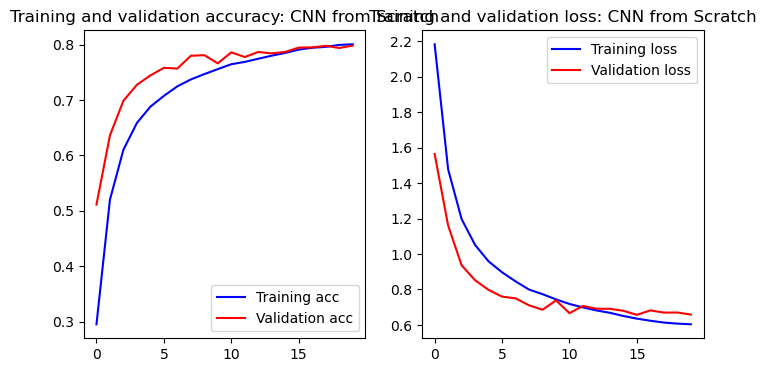

In [7]:
# Function to build a simple CNN model
def build_scratch_model(input_shape, num_classes):
    model = models.Sequential([
        layers.Rescaling(1./255, input_shape=input_shape),
        layers.Conv2D(32, (3, 3), activation='relu'),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(64, (3, 3), activation='relu'),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(64, (3, 3), activation='relu'),
        layers.MaxPooling2D((2, 2)),
        layers.Flatten(),
        layers.Dense(128, activation='relu'),
        layers.Dropout(0.5),
        layers.Dense(num_classes, activation='softmax', dtype='float32')  # Explicitly set dtype
    ])
    model.compile(optimizer='adam',
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])
    return model

# Train and evaluate the scratch model
input_shape = (64, 64, 3)

model_scratch = build_scratch_model(input_shape, num_classes)
history_scratch = model_scratch.fit(
    train_ds,
    validation_data=val_ds,
    epochs=20,
    batch_size=batch_size
)

# Evaluate on test set
test_loss, test_acc = model_scratch.evaluate(test_ds)
print(f"Scratch Model Test Accuracy: {test_acc:.2f}")

# Function to visualize training history
def plot_history(history, title):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs = range(len(acc))

    plt.figure(figsize=(8, 4))
    plt.subplot(1, 2, 1)
    plt.plot(epochs, acc, 'b', label='Training acc')
    plt.plot(epochs, val_acc, 'r', label='Validation acc')
    plt.title(f'Training and validation accuracy: {title}')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(epochs, loss, 'b', label='Training loss')
    plt.plot(epochs, val_loss, 'r', label='Validation loss')
    plt.title(f'Training and validation loss: {title}')
    plt.legend()

    plt.show()

# Plot history
plot_history(history_scratch, "CNN from Scratch")

# Transfer learning

Epoch 1/20
6296/6296 [==============================] - 118s 18ms/step - loss: 4.7206 - accuracy: 0.1234 - val_loss: 4.0157 - val_accuracy: 0.2328
Epoch 2/20
6296/6296 [==============================] - 113s 18ms/step - loss: 3.4639 - accuracy: 0.2662 - val_loss: 2.8198 - val_accuracy: 0.3258
Epoch 3/20
6296/6296 [==============================] - 112s 18ms/step - loss: 1.8346 - accuracy: 0.5800 - val_loss: 1.0969 - val_accuracy: 0.8109
Epoch 4/20
6296/6296 [==============================] - 113s 18ms/step - loss: 1.0151 - accuracy: 0.8305 - val_loss: 0.9417 - val_accuracy: 0.8520
Epoch 5/20
6296/6296 [==============================] - 116s 18ms/step - loss: 0.8125 - accuracy: 0.8813 - val_loss: 0.8566 - val_accuracy: 0.8675
Epoch 6/20
6296/6296 [==============================] - 119s 19ms/step - loss: 0.6692 - accuracy: 0.9125 - val_loss: 0.8132 - val_accuracy: 0.8691
Epoch 7/20
6296/6296 [==============================] - 120s 19ms/step - loss: 0.5574 - accuracy: 0.9350 - val_loss: 0

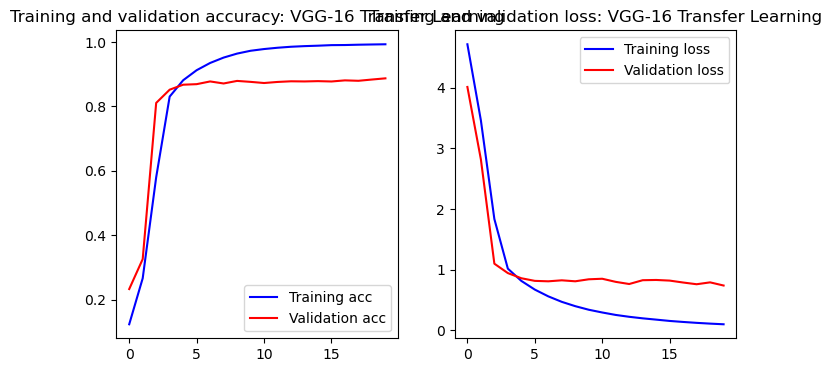

In [4]:
# Load VGG-16 Model with Transfer Learning and Fine-Tuning
def build_transfer_model(input_shape, num_classes):
    base_model = VGG16(
        weights='imagenet',
        input_shape=input_shape,
        include_top=False
    )

    # Unfreeze the last 8 layers for fine-tuning
    for layer in base_model.layers[:-8]:
        layer.trainable = False
    for layer in base_model.layers[-8:]:
        layer.trainable = True

    model = models.Sequential([
        base_model,
        layers.Flatten(),
        layers.Dense(1024, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.001)),
        layers.Dropout(0.5),
        layers.Dense(512, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.001)),
        layers.Dropout(0.5),
        layers.Dense(num_classes, activation='softmax', dtype='float32')  # Explicitly set dtype
    ])

    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.00001),
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])
    return model

# Train and evaluate the transfer model
input_shape = (64, 64, 3)
model_transfer = build_transfer_model(input_shape, num_classes)

history_transfer = model_transfer.fit(
    train_ds,
    validation_data=val_ds,
    epochs=20,
    batch_size=batch_size
)

# Evaluate on test set
test_loss, test_acc = model_transfer.evaluate(test_ds)
print(f"Transfer Learning Model Test Accuracy: {test_acc:.2f}")

# Function to visualize training history
def plot_history(history, title):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs = range(len(acc))

    plt.figure(figsize=(8, 4))
    plt.subplot(1, 2, 1)
    plt.plot(epochs, acc, 'b', label='Training acc')
    plt.plot(epochs, val_acc, 'r', label='Validation acc')
    plt.title(f'Training and validation accuracy: {title}')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(epochs, loss, 'b', label='Training loss')
    plt.plot(epochs, val_loss, 'r', label='Validation loss')
    plt.title(f'Training and validation loss: {title}')
    plt.legend()

    plt.show()

plot_history(history_transfer, "VGG-16 Transfer Learning")


# Comparison and Testing

In [8]:
# Compare inference times
import time

def measure_inference_time(model, dataset):
    start_time = time.time()
    model.evaluate(dataset)
    elapsed_time = time.time() - start_time
    return elapsed_time

inference_time_scratch = measure_inference_time(model_scratch, test_ds)
inference_time_transfer = measure_inference_time(model_transfer, test_ds)

print(f"Inference Time - Scratch Model: {inference_time_scratch:.2f}s")
print(f"Inference Time - Transfer Model: {inference_time_transfer:.2f}s")


1049/1049 [==============================] - 9s 9ms/step - loss: 0.7624 - accuracy: 0.8827
Inference Time - Scratch Model: 5.02s
Inference Time - Transfer Model: 9.24s


In [10]:
# Final test using self-taken images
from tensorflow.keras.preprocessing import image

def predict_gesture(model, img_path, class_names):
    img = image.load_img(img_path, target_size=(64, 64))
    img_array = image.img_to_array(img)
    img_array = tf.expand_dims(img_array, 0)  # Create batch dimension

    predictions = model.predict(img_array)
    predicted_class = class_names[np.argmax(predictions)]
    return predicted_class

gesture_images = ['images/image_like.jpg',
                  'images/image_ok.jpg',
                  'images/image_stop.jpg',
                  'images/image_two.jpg']

for img_path in gesture_images:
    predicted_gesture = predict_gesture(model_transfer, img_path, class_names)
    print(f"Prediction for {img_path}: {predicted_gesture}")


1/1 [==============================] - 0s 421ms/step
Prediction for images/image_like.jpg: like
1/1 [==============================] - 0s 22ms/step
Prediction for images/image_ok.jpg: ok
1/1 [==============================] - 0s 23ms/step
Prediction for images/image_stop.jpg: stop
1/1 [==============================] - 0s 25ms/step
Prediction for images/image_two.jpg: two_up
